# Introduction

**ML model for emulating microphysics in a supercell (climate) test case using Keras**

* A canonical microphysics process consits of 4 flow variables - temperature, water vapor, cloud water (liquid), and precipitation/rain (liquid).
    - The <a href="https://doi.org/10.1016/0169-8095(94)00090-Z">Kessler scheme</a> is a canonical scheme used to understand the roles of cloud conversion, accretion, evaporation, and entrainment in shaping the distribution of water vapor, cloud, and precipitation.
    - It is an idealized microphysics process without considering the ice phase.
    - Many available schemes have followed the Kessler scheme.

![microphysics](images/microphysics_Kessler.png)

* **Objective**: Emulate the evolution of microphysics of a cell from the information from its neighboring cells in a [supercell](https://en.wikipedia.org/wiki/Supercell) test case. The [Kessler scheme](https://doi-org.ornl.idm.oclc.org/10.1016/0169-8095(94)00090-Z) is used for the actual emulation.

![microphysics](images/microphysics_ML_singlecell.png)

* **Input data**: Microphysics of a single grid cell with dry air density
    - Size of a single input to NN model: $N_{\text{micro}} + 1 = 5$ for 2D/3D simulation
* **Output data**: Microphysics of the given cell after emmulation (at next time step)
    - Size of corresponding output from NN model: $[N_{\text{micro}}] = [4]$ for 2D/3D simulation
* **Training data size**:
    - Input:  $5 \times N_{\text{train}}$
    - Output: $4  \times N_{\text{train}}$

* **Data generation**:
    - Data will be downloaded.
    - If the user would like to change the amount of data, see the notebook [kessler_netcdf_to_numpy.ipynb](kessler_netcdf_to_numpy.ipynb)

**By Matt Norman and Murali Gopalakrishnan Meena, ORNL**

# Import libraries

In [1]:
# Import the necessary packages
import numpy as np
from sklearn.metrics import r2_score

import os
# The line below reduces tensorflow output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, ReLU, Softmax, LeakyReLU, PReLU, ELU, ThresholdedReLU
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
# The option below improves the speed of model.predict() (see below)
tensorflow.compat.v1.disable_eager_execution()

import matplotlib.pyplot as plt

# Read in data, scale, and split
The input and output training data is pre-shuffled.
* Read it in
* Generate min-max scaling numbers for each variable for input and output separately
* Scale inputs and outputs to $x \in [0,1]$
* Split it into training and testing datasets

**You can change `test_split` below to use more or less of the overall data in the training**.
* Using more data in training can improve accuracy but reduces your ability to test how well your model does on data it has never seen before.
* A larger value for `test_split` defines the proportion of overall training samples to be used in testing that is never seen during neural network model training / optimization.

In [2]:
path = f'supercell_kessler_data.npz'
data_link = "https://www.dropbox.com/s/6rh5at6lic377ax/supercell_kessler_data.npz?dl=0"

# Download the data if necessary
if ( not os.path.isfile(path) ):
    print(f"Downloading data from:\n {data_link}...")
    !wget {data_link} -O {path}

# Read pre-shuffled inputs and outputs
npzfile = np.load(path)
input_from_file  = npzfile['input_from_file']
output_from_file = npzfile['output_from_file']

# Total number of sampes in the file
total_samples = input_from_file.shape[0]

# Number of samples I want to use for training in this notebook
num_samples = total_samples

#Get dimension sizes
num_vars_in  = input_from_file .shape[1]
num_vars_out = output_from_file.shape[1]
num_stencil  = input_from_file .shape[2]

# This is a single-cell (non-stencil) Neural Network (NN) modeling approach
# The zeroth stencil index is the cell being predicted
# Load inputs and outputs from file
input  = np.copy(input_from_file [:num_samples,:,0])
output = np.copy(output_from_file[:num_samples,:  ])

# Get dimensions sizes
print('Getting shapes')
print(f'Input shape = {input.shape}')
print(f'Output shape = {output.shape}')
print(f'Total number of data points = {num_samples}')

# Split the dataset into testing and training portions
test_split = 0.2   # 20% of the data will never be trained on (for testing)
num_train_samples = int((1-test_split)*num_samples)
num_test_samples  = num_samples-num_train_samples

print('Scaling the input and output data and saving the scaling parameters')

sclrArrayIn  = np.ndarray(shape=[num_vars_in ,2],dtype=np.single)
sclrArrayOut = np.ndarray(shape=[num_vars_out,2],dtype=np.single)

for ivar in range(num_vars_in) :
  sclrArrayIn [ivar,0] = np.amin(input [:num_train_samples,ivar])
  sclrArrayIn [ivar,1] = np.amax(input [:num_train_samples,ivar])
for ivar in range(num_vars_out) :
  sclrArrayOut[ivar,0] = np.amin(output[:num_train_samples,ivar])
  sclrArrayOut[ivar,1] = np.amax(output[:num_train_samples,ivar])

np.savetxt('supercell_kessler_stencil_input_scaling.txt' , sclrArrayIn , fmt="%s")
np.savetxt('supercell_kessler_stencil_output_scaling.txt', sclrArrayOut, fmt="%s")

for ivar in range(num_vars_in) :
  input [:,ivar] = (input [:,ivar] - sclrArrayIn [ivar,0]) / (sclrArrayIn [ivar,1] - sclrArrayIn [ivar,0])
for ivar in range(num_vars_out) :
  output[:,ivar] = (output[:,ivar] - sclrArrayOut[ivar,0]) / (sclrArrayOut[ivar,1] - sclrArrayOut[ivar,0])

print('Splitting the dataset into training and testing portions')

# Training data
input_train  = input [:num_train_samples, :]
output_train = output[:num_train_samples, :]
# Testing data
input_test   = input [num_train_samples:, :]
output_test  = output[num_train_samples:, :]


Getting shapes
Input shape = (9118906, 5)
Output shape = (9118906, 4)
Total number of data points = 9118906
Scaling the input and output data and saving the scaling parameters
Splitting the dataset into training and testing portions


# Create and train Neural Network

## Basic idea of a Neural Network
Here we will create a neural network architecture and fit it to the data. Below is a diagram from [a towardsdatascience article](https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37) that gives a visual depiction of a "dense, feed-forward neural network":

<img src="https://miro.medium.com/max/1400/1*eJ36Jpf-DE9q5nKk67xT0Q.jpeg" width=500/>

The neural network stores "hidden layers" of "neurons" or "units" (the open circles), which are just scalar floating point values. A set of weights connect each neuron of the previous layer to each neuron of the current layer. Each weight is a scalar floating point value, and the set of weights is represented as a matrix multiplication followed by a vector addition and a non-linear ["activation function"](https://en.wikipedia.org/wiki/Activation_function). I.e., if the previous layer of neurons is the vector `x`, then the current layer of neurons, `y`, is computed as $y = \phi \left( Ax + b \right)$, where $Ax$ is matrix-vector multiplication, $+b$ is component-wise vector addition, and $\phi\left(\ldots\right)$ is a component-wise application of a non-linear function (e.g., one of [these](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions)) to a vector. The "trainable parameters" of the neural network model that we fit to the training data lie in the weights (`A` and `b`).

To fully mathematically describe the neural network imaged above with two hidden layers, let us assume the input is labeled as $x_I$, the output is labeled as $x_O$, and the hidden layers are labeled as $h_1$ and $h_2$. The model is as follows:
* $h_1 = {\phi}_1\left( A_1 x_I + b_1 \right)$
* $h_2 = {\phi}_2\left( A_2 h_1 + b_2 \right)$
* $x_O = {\phi}_3\left( A_3 h_2 + b_3 \right)$

Notice that the model is basically nesting operations successively around the input values. The last activation function ${\phi}_3$ is not always used, the activations functions do not have to all be the same, and the hidden layers can have different numbers of neurons or units. To train this particular model, we would optimize the trainable parameters in the matrices $A_1, A_2, A_3$ and the vectors $b_1, b_2, b_3$.

The so-called "hyper-parameters" (which might be better called meta-parameters?) are one step above the trainable weights, and they describe (1) the neural network model architecture and (2) the training / optimization process.

### Hyper-parameters defining the model architecture
Below are some of the parameters you can experiment with:
* Number of "hidden layers" ("depth" of the network)
  - The model below has only one "hidden layer". Sometimes it can be helpful to have more than one hidden layer to better approximate non-linear functions; and sometimes, you'll find that it might not be helpful.
  - To add another hidden layer for this particular model, you should add a `Dense()` followed by an activation function like the `LeakyReLU()` we use. 
    * Please note that Keras's definition of a "layer" is different than what we've been using. What we've been calling a "hidden layer", Keras calls a "state". In Keras, a "layer" is the set of mathematical operations that **connect** states. Every ML package has its own separate terminology for different aspects of model architecture, training, and workflow. Term overloading is pretty common in the ML world, unfortunately.
  - Uncomment the two commented lines of code to create a second layer. Feel free to try even more.
* Number of "neurons" per layer
  - Each layer has a vector of floating point values ("neurons"), which Keras calls these `units`. Increasing the number of neurons can allow the model to learn more complex behavior. Yet, it can also make the model harder to train.
  - Try increasing the `units` parameter in one or more of your `Dense` layers and see what happens.
* Type of activation function(s):
  - We use `LeakyReLU()` with a slope parameter of `0.1`. You can try different slopes. You can also try different activation functions using the link here: https://keras.io/api/layers/activation_layers/
    * For these, you'll use the syntax `model.add( [LayerName]([parameters]) )`.


In [3]:
# Create the Keras Neural Network (Dense, Feed-Forward)
model = Sequential()

# This dense "layer" A x + b to transform 5 input variables into 10 hidden values
model.add( Dense(units=10,input_dim=num_vars_in,kernel_initializer="RandomUniform") )
model.add( LeakyReLU(alpha=0.1) )

# Uncomment the lines below to add a second hidden layer with ten neurons.
# This dense "layer" uses A x + b to transform 10 hidden values into 10 different hidden values
# model.add( Dense(units=10,kernel_initializer="RandomUniform") )
# model.add( LeakyReLU(alpha=0.1) )

# This dense "layer" uses A x + b to transform 10 hidden values 4 output values
model.add( Dense(num_vars_out,kernel_initializer="RandomUniform") )

### Hyper-parameters defining the training process
* Type of optimizer
  - Below, we use `Nadam` or the Adam optimizer with "Nesterov momentum" added in (affects how the learning rate changes from one epoch to the next).
  - Try one of the other optimizers at this link: https://keras.io/api/optimizers/#available-optimizers
    * In particular, definitely try the `SGD` optimizer with different learning rates (10, 1, 0.1, 0.01, 0.001, and so on). See how it affects your error and the speed at which the model trains. But plese do play around with any you want.
* Loss function
  - Since this is in essence a "regression problem", feel free to try any of the "regression losses" at this link: https://keras.io/api/losses/#regression-losses
* Number of "epochs": Each "epoch" is as follows:
  1. Randomly shuffle the data
  2. Split off a random `validation_split` proportion for validation for the epoch that is not use for training
  3. Pass through the data in "batches". For each batch:
    1. Accumulate the loss function over all samples in the batch
    2. Compute the gradient of each model parameter w/r to the accumulated loss
    3. Update each model parameter in the negative gradient direction (tending toward zero loss) according to the learning rate specified by the optimizer
  * As the number of epochs increases, you will typically see one of the following behaviors in your error:
    1. **Underfitting**: Training and validation error decrease but have not yet converged, or they converge to a very poor error. You can improve this by training with more epochs and / or increasing the number of neurons / layers in your model.
    2. **Overfitting**: The training error continues to decrease and perhaps converges while the validation error plateaus at a much worse error or begins to increase with each epoch. You can improve this via one of the following: (a) Use fewer epochs; (b) Obtain more training data; (c) Use fewer neurons / layers; (d) Use "regularization"; (e) Use larger batches; (f) Use larger proportaions of the training data for testing and per-epoch validation.
    3. **Learning rate too large**: Both training and validation error oscillate wildly
    4. **Learning rate too small**: Error doesn't seem to change much at all (your learning rate might be too small)
    5. **Goldilocks zone**: Both training and validation error asymptote to a similar error that is sufficiently low.
  * Change the number of epochs by changing the `epochs` parameter to `model.fit()`
* Batch size: Model parameters are updated for each batch using a combined error metric. Therefore, larger batches respond less to individual training samples, which can reduce overfitting, but can increase error for individual samples.
  - Feel free to increase or decrease the batch size and see what happens.
  - Beware that **smaller batch sizes take longer to train!** So do not decrease it too much. 
* Validation split: In each epoch, a random `validation_split` proportion of the data is **not** used for training in that epoch. Larger validation splits can reduce overfitting but can also increase error. There is a balance to be found.
  - Feel free to change this to any value between zero and one. (A validation split of exactly one means no training is performed, though). 

In [4]:
# The "compile" method defines some of the training configurations for the model
model.compile(loss='mse', optimizer=Nadam(), metrics=['mean_absolute_error'])

# Let's see what the model looks like
print(model.summary())

# Training will likely take a few minutes to complete.
history = model.fit(input_train, output_train, epochs=10, batch_size=1024, validation_split=0.2, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 104
Trainable params: 104
Non-trainable params: 0
_________________________________________________________________
None
Train on 5836099 samples, validate on 1459025 samples
Epoch 1/10
5831680/5836099 [============================>.] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0115

/home/imn/miniconda3/envs/ml/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5836099/5836099 [==============================] - 22s 4us/sample - loss: 0.0018 - mean_absolute_error: 0.0115 - val_loss: 1.9927e-06 - val_mean_absolute_error: 9.8445e-04
Epoch 2/10
5836099/5836099 [==============================] - 21s 4us/sample - loss: 7.1391e-07 - mean_absolute_error: 5.4016e-04 - val_loss: 2.0830e-07 - val_mean_absolute_error: 3.5388e-04
Epoch 3/10
5836099/5836099 [==============================] - 21s 4us/sample - loss: 2.5387e-07 - mean_absolute_error: 3.3859e-04 - val_loss: 2.0397e-07 - val_mean_absolute_error: 3.7820e-04
Epoch 4/10
5836099/5836099 [==============================] - 21s 4us/sample - loss: 1.9414e-07 - mean_absolute_error: 2.9332e-04 - val_loss: 2.1434e-08 - val_mean_absolute_error: 7.3554e-05
Epoch 5/10
5836099/5836099 [==============================] - 20s 4us/sample - loss: 1.7485e-07 - mean_absolute_error: 2.7747e-04 - val_loss: 5.4761e-07 - val_mean_absolute_error: 5.6323e-04
Epoch 6/10
5836099/5836099 [==============================] - 21

## Plot of loss over epochs during training
As mentioned earlier, pay attention to how the training and validation losses (or errors) change as we progress through further epochs. See if it lies in one of the five situations enumerated above.

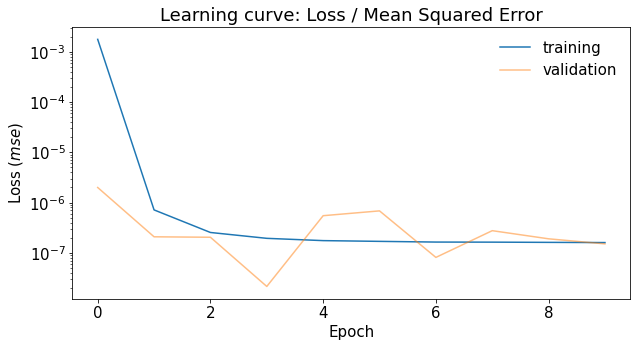

In [5]:
# Feel free to change font size to your preferences here.
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(1,figsize=(10,5),facecolor="1")
axs.set_title('Learning curve: Loss / Mean Squared Error')
axs.plot(history.history['loss'], label='training')
axs.plot(history.history['val_loss'], label='validation', alpha=0.5)
axs.set_xlabel('Epoch'); axs.set_ylabel(f'Loss ($mse$)')
axs.set_yscale('log')
axs.legend(frameon=False);

# Use the NN model to predict outputs based on the inputs

In [6]:
# This will likely take 30 seconds or so
predict_test = model.predict( input_test )

/home/imn/miniconda3/envs/ml/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


# Compare predicted outputs to actual outputs for testing data the NN model has never seen before during training

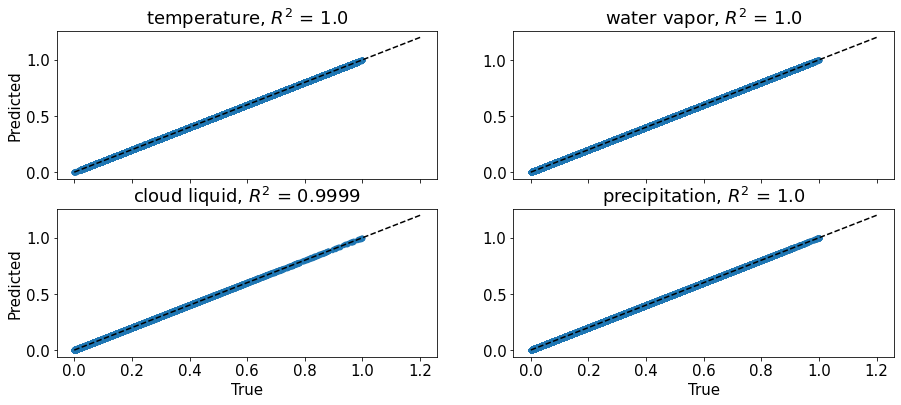

In [7]:
titlestr = np.array(['temperature','water vapor','cloud liquid','precipitation'])

fig, axs = plt.subplots(2,2,figsize=(15,6),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(output_test[:,i],predict_test[:,i],s=20)
    axs[i].plot(np.linspace(0,1.2),np.linspace(0,1.2),'--',color='k')
    r2 = r2_score(output_test[:,i],predict_test[:,i])
    axs[i].set_title(f'{titlestr[i]}, $R^2$ = {r2:0.4}')
axs[2].set_xlabel(r'True'); axs[3].set_xlabel(r'True');
axs[0].set_ylabel(r'Predicted'); axs[2].set_ylabel(r'Predicted');

# Take a look at the maximum and mean relative $L_1$ errors

For the mean relative test bias, keep in mind that this is the expected value to be added to that variable **every time the model is run**. So the temperature, for instance, will drift by that value every model time step. That drift will add up quickly as the model continues to progress in time.

In [8]:
print(f'Variables:\t\t\t{titlestr}')
print( 'Maximum relative test errors:\t' , np.amax(np.abs(output_test-predict_test),axis=0) / np.amax(np.abs(output_test),axis=0) )
print( 'Mean relative test errors:\t'    , np.mean(np.abs(output_test-predict_test),axis=0) / np.mean(np.abs(output_test),axis=0) )
print( 'Mean relative test bias:\t'      , np.mean(output_test-predict_test,axis=0) / np.mean(np.abs(output_test),axis=0) )

Variables:			['temperature' 'water vapor' 'cloud liquid' 'precipitation']
Maximum relative test errors:	 [0.00506735 0.0039123  0.00568604 0.00492949]
Mean relative test errors:	 [0.00080251 0.00247717 0.04042332 0.00340743]
Mean relative test bias:	 [ 0.00080149 -0.00247646 -0.03998468 -0.00239937]


# Save the model weights

In [9]:
# For inference: Serialize model to JSON
model_json = model.to_json()
with open('supercell_kessler_singlecell_model_weights.json', 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('supercell_kessler_singlecell_model_weights.h5')
print('Saved model to disk')

Saved model to disk
